<a href="https://colab.research.google.com/github/victor-roris/NLPlearning/blob/master/text_classification/NLPModel_MultiLabel_Transformers_KTRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification With Hugging Face Transformers in TensorFlow Using ktrain

Text classification can be:

 * Binary: it classifies text in one (and only one) of two categories (e.g., sentiment analysis)
 * MultiClass: it classifies text in one (and only one) of more than two categories (e.g, classify a newspaper texts by its category: [link](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed))
 * MultiLabel: it classifies text in zero, one or more categories at same time (e.g, classify the plot text of a movie in its possible genres: [link](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff))

In this notebook, we implement a multilabel text classificator usig KTrain. KTrain is a library over the Transformers package. 

Used datadaset from [link](https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8).


## Installation

In [0]:
!pip install ktrain

KTrain needs tensorflow 2

In [0]:
# In a normal environment (it can fail in google colab)
! pip install -q tensorflow_gpu>=2.0

In [0]:
# Colab upgrade of tensorflow v2 --> Restart environment!
! tf_upgrade_v2 \
  --intree my_project/ \
  --outtree my_project_v2/ \
  --reportfile report.txt

In [0]:
import tensorflow
tensorflow.__version__

'2.1.0'

## DATA

We are going to use [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) with movie data.

### Get the raw data

Download and untar the data files

In [0]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2020-02-28 17:18:36--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M   642KB/s    in 74s     

2020-02-28 17:19:51 (631 KB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [0]:
! tar -zxvf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


In [0]:
! ls MovieSummaries/

character.metadata.tsv	name.clusters.txt   README.txt
movie.metadata.tsv	plot_summaries.txt  tvtropes.clusters.txt


### Load the data

Load and combine the data files in a clean dataframe

In [0]:
import pandas as pd

Load the metadata file

In [0]:
meta = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
genres = meta[["movie_id","movie_name","genre"]]

print(f'Number of films in genre dataframe: {len(genres)}')
genres.head()

Number of films in genre dataframe: 81741


,movie_id,movie_name,genre
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}"


Load the plot file

In [0]:
plots = pd.read_csv("MovieSummaries/plot_summaries.txt", sep = '\t', header = None)
plots.columns = ["movie_id", "plot"]
print(f'Number of films in plot dataframe: {len(plots)}')
plots.head()

Number of films in plot dataframe: 42303


,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Combine both data

In [0]:
genres['movie_id'] = genres['movie_id'].astype(str)
plots['movie_id'] = plots['movie_id'].astype(str)
movies = pd.merge(plots, genres, on = 'movie_id')
print(f'Number of films : {len(movies)}')
movies.head()

Number of films : 42204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


Clean the genre column

In [0]:
import json
genres_lists = []
for i in movies['genre']:
  genres_lists.append(list(json.loads(i).values()))

In [0]:
movies['genre'] = genres_lists
movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."


### Transform dataframe to multi-label format

Multi-label models need a specific format for the input dataframes. They need the dataframe includes each genre as a column, with a value of 1 or 0 by movie if it has the genre or not, respectively. 

Generate the binary multilabel columns by genre

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(movies['genre'])
 # transform target variable
y = multilabel_binarizer.transform(movies['genre'])
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Concat the binary multilabel columns to the final dataframe

In [0]:
for idx, genre in enumerate(multilabel_binarizer.classes_):
  movies[genre] = y[:,idx]
movies.head()

,movie_id,plot,movie_name,genre,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,Airplanes and airports,Albino bias,Alien Film,Alien invasion,Americana,Animal Picture,Animals,Animated Musical,Animated cartoon,Animation,Anime,Anthology,Anthropology,Anti-war,Anti-war film,Apocalyptic and post-apocalyptic fiction,Archaeology,Archives and records,Art film,Auto racing,Avant-garde,B-Western,B-movie,Backstage Musical,Baseball,Beach Film,...,Star vehicle,Statutory rape,Steampunk,Stoner film,Stop motion,Superhero,Superhero movie,Supermarionation,Supernatural,Surrealism,Suspense,Swashbuckler films,Sword and Sandal,Sword and sorcery,Sword and sorcery films,Tamil cinema,Teen,Television movie,The Netherlands in World War II,Therimin music,Thriller,Time travel,Tokusatsu,Tollywood,Tragedy,Tragicomedy,Travel,Vampire movies,War effort,War film,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr...",0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


List of genres

In [0]:
label_columns = list(movies.drop(labels=['movie_id','plot','movie_name', 'genre'], axis=1).columns.values)
print(f'Number of labels : {len(label_columns)}')
label_columns[0:10]

Number of labels : 363


['Absurdism',
 'Acid western',
 'Action',
 'Action Comedy',
 'Action Thrillers',
 'Action/Adventure',
 'Addiction Drama',
 'Adult',
 'Adventure',
 'Adventure Comedy']

### Data analysis

In [0]:
df_mgenr = movies.drop(['movie_id', 'plot', 'movie_name', 'genre' ], axis=1)
counts = []
categories = list(df_mgenr.columns.values)
for i in categories:
    counts.append((i, df_mgenr[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments']).sort_values(by='number_of_comments', ascending=False)
df_stats.head()

,category,number_of_comments
114,Drama,19134
75,Comedy,10467
288,Romance Film,6666
343,Thriller,6530
2,Action,5868


Text(0.5, 0, 'category')

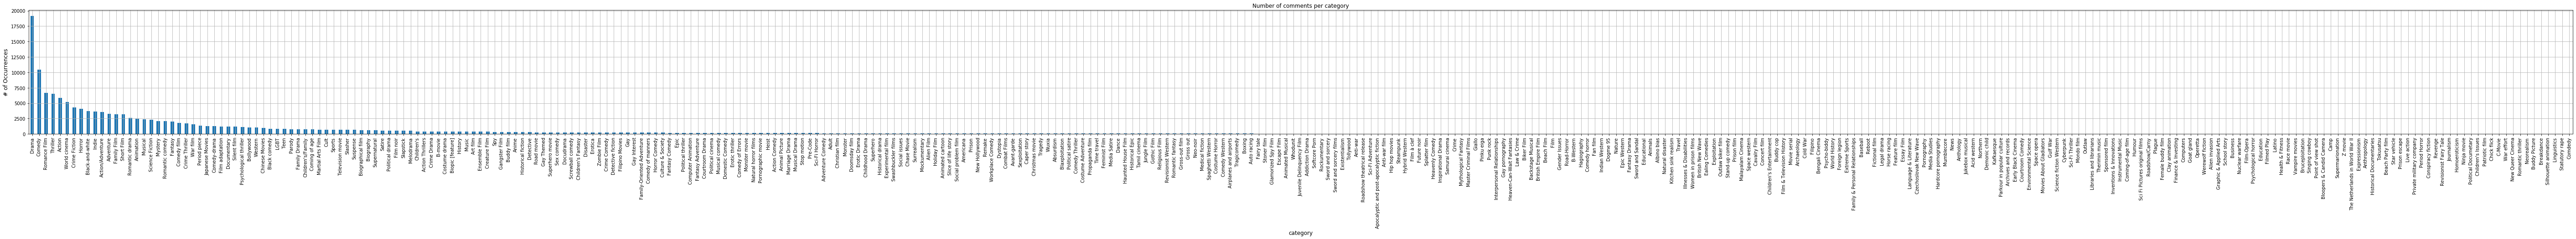

In [0]:
import matplotlib.pyplot as plt
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(100, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, '# of labels')

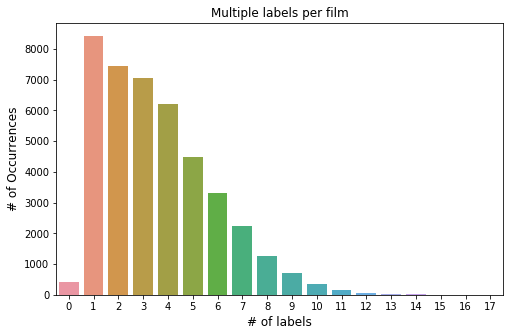

In [0]:
import seaborn as sns
rowsums = movies.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple labels per film")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of labels', fontsize=12)

### Reduce example dataset

The original dataset is very unbalanced. The original analysis of this dataset showed that the accuracy is extremely poor, value of 0,09. 

For this example, we want test multi-label model. For this reason, we are going to select only the labels with a representative number of examples.

In [0]:
print(f'Number of orginal genres: {len(label_columns)}')

Number of orginal genres: 363


In [0]:
valid_genres = df_stats.category[0:20].values

In [0]:
print(f'Number of selected genres: {len(valid_genres)}')

Number of selected genres: 20


In [0]:
excluded_genres = list(set(label_columns) - set(valid_genres))
print(f'Number of droped genres: {len(excluded_genres)}')

Number of droped genres: 343


In [0]:
movies = movies.drop(labels=excluded_genres, axis=1)
label_columns = list(movies.drop(labels=['movie_id','plot','movie_name', 'genre'], axis=1).columns.values)

Drop the rows without a valid genre

In [0]:
print(f'Number of films originally considerated : {len(movies)}')

Number of films originally considerated : 42204


In [0]:
movies['nlabels'] = movies[valid_genres].apply(lambda row: row.sum(), axis=1 )
movies = movies[movies['nlabels']>0]
movies = movies.drop(labels=['nlabels'], axis=1).reset_index(drop=True)

In [0]:
print(f'Number of films finally considerated : {len(movies)}')

Number of films finally considerated : 38885


In [0]:
movies.head()

,movie_id,plot,movie_name,genre,Action,Action/Adventure,Adventure,Animation,Black-and-white,Comedy,Crime Fiction,Drama,Family Film,Horror,Indie,Musical,Mystery,Romance Film,Romantic comedy,Romantic drama,Science Fiction,Short Film,Thriller,World cinema
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr...",1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]",1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema...",0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1


Text(0.5, 0, '# of categories')

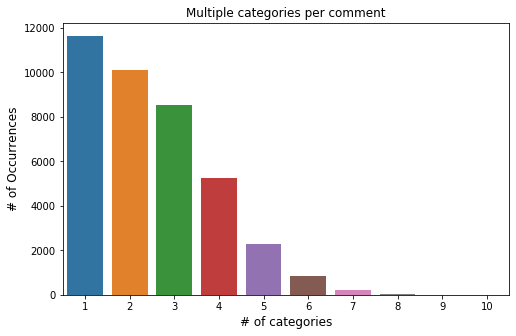

In [0]:
import seaborn as sns
rowsums = movies.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## TRAIN MODEL

### Split data to train and validation datasets

In [0]:
from ktrain import text
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(movies.drop(labels=['movie_id','movie_name', 'genre'], axis=1), 
                                                                   'plot', # name of column containing review text
                                                                   label_columns=label_columns,
                                                                   maxlen=75, 
                                                                   max_features=100000,
                                                                   #preprocess_mode='standard',
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)

using Keras version: 2.2.4-tf
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


### Configure the NVIDIA driver

In [0]:
!nvidia-smi

Fri Feb 28 17:41:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

### Select model

In [0]:
import ktrain
from ktrain import text

In [0]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? True
maxlen is 75
done.


In [0]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

### Estimate the Learning Rate

simulating training for different learning rates... this may take a few moments...
Train on 34996 samples
Epoch 1/2
34996/34996 [==============================] - 586s 17ms/sample - loss: 0.4430 - accuracy: 0.7747
Epoch 2/2
13952/34996 [==========>...................] - ETA: 5:40 - loss: 0.4577 - accuracy: 0.8703

done.


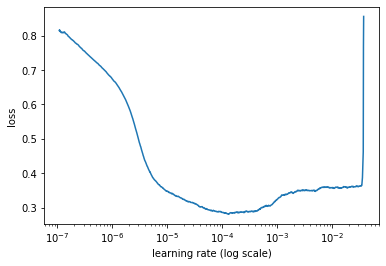

In [0]:
learner.lr_find(show_plot=True, max_epochs=2)

### Train the Model

In [0]:
learner.fit_onecycle(lr=5e-5, epochs=4)



begin training using onecycle policy with max lr of 5e-05...
Train on 34996 samples, validate on 3889 samples
Epoch 1/4
34996/34996 [==============================] - 593s 17ms/sample - loss: 0.3054 - accuracy: 0.8770 - val_loss: 0.2594 - val_accuracy: 0.8936
Epoch 2/4
34996/34996 [==============================] - 589s 17ms/sample - loss: 0.2430 - accuracy: 0.9017 - val_loss: 0.2538 - val_accuracy: 0.8958
Epoch 3/4
34996/34996 [==============================] - 589s 17ms/sample - loss: 0.2042 - accuracy: 0.9175 - val_loss: 0.2526 - val_accuracy: 0.8972
Epoch 4/4
34996/34996 [==============================] - 589s 17ms/sample - loss: 0.1490 - accuracy: 0.9423 - val_loss: 0.2721 - val_accuracy: 0.8953


## EVALUATION

### Confusion matrix


In [0]:
s_ycategories = y_test.tolist()
s_ycategories = [i for i in s_ycategories]
# s_ycategories.sort() 
# s_ycategories = [i for i in s_ycategories]

**KTRAIN: multilabel confusion matrices not yet supported**

In [0]:
#confusion_matrix = learner.validate(class_names=s_ycategories)
# confusion_matrix

I use a manual approximation based in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [0]:
from tqdm import tqdm

#Predict manually all the x_text inputs
p_ycategories = []
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
for toktext in tqdm(x_test[0]):
  rawtext = preproc.undo(toktext)
  proba = predictor.predict_proba(rawtext)
  pred = [ 1 if p>0.5 else 0 for p in proba ]
  p_ycategories.append(pred)
p_ycategories[0]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

In [0]:
print(len(p_ycategories))
print(len(s_ycategories))

3889
3889


In [0]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

confusion_matrix = multilabel_confusion_matrix(np.array(s_ycategories), np.array(p_ycategories))

In [0]:
confusion_matrix.shape

(20, 2, 2)

Confusion matrix to the label 2 - category : Adventure


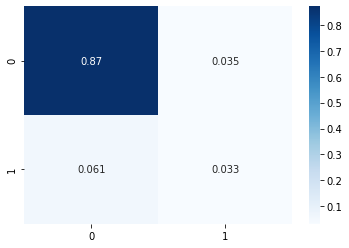

In [0]:
import seaborn as sns
import numpy as np

cat2review = 2

print(f'Confusion matrix to the label {cat2review} - category : {label_columns[cat2review]}')
sns.heatmap(confusion_matrix[cat2review]/np.sum(confusion_matrix[cat2review]), cmap='Blues', annot=True)

### Prediction and explicability

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor

In [0]:
example_index = 0
exp_text = movies.iloc[example_index]['plot']
exp_text_label = movies.iloc[example_index][label_columns]
print(f"Explicability test: ")
print(f"\t - sentence: {exp_text}")
print(f"\t - true label: \n{exp_text_label}")

In [0]:
proba = predictor.predict_proba(exp_text)
proba

In [0]:
prob = [ 1 if p>0.5 else 0 for p in proba ]
prob

In [0]:
list(exp_text_label.values)

### Inspect the model

In [0]:
# This function only display by console the results
learner.view_top_losses(n=10, preproc=preproc)